# Operation Mind Shield: Decoding Alzheimer's
#### **Full Name:** Jeroen Van der Mynsbrugge
#### **Link to SDS Profile:** https://community.superdatascience.com/u/eca8c443

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

Source: Rabie El Kharoua, _Alzheimer's Disease Dataset_, Kaggle, 2024, https://doi.org/10.34740/KAGGLE/DSV/8668279.

In [4]:
data = pd.read_csv("../../data/alzheimers_disease_data.csv")

In [ ]:
data.head()

### Examine datatypes and check for missing data

In [ ]:
data.info()

=> The dataset has no missing values in any of the columns.

### Remove columns with irrelevant information

In [7]:
data.drop(["PatientID", "DoctorInCharge"], axis=1, inplace=True)

In [ ]:
data.head()

(Dropping the "DoctorInCharge" dummy-column also ensures that the target variable "Diagnosis" ends up in the last column.)

### Exploratory data analysis

In [ ]:
data.columns

Because the categorical variables in this dataset are already encoded as integers, we'll create masks to separate them from the numerical variables to facilitate EDA:

In [10]:
num_columns = ['Age','BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
               'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']
cat_columns = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression',
               'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness', 'Diagnosis']

#### Numerical features

In [ ]:
data[num_columns].describe()

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.histplot(data=data, x=column, bins=15, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.boxplot(data=data[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

=> None of the numerical feature columns seem to have any outliers. All features seem to have fairly uniform distributions.

In [ ]:
corr_matrix = data[num_columns].corr()
corr_matrix

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt="0.2f", square=True)
plt.show()

=> No significant correlation between any of the numerical features, suggesting no or limited linear relationships. Non-linear models will probably be required to capture interactions.

#### Categorical features

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(cat_columns):
    sns.countplot(x=column, data=data, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

### Feature selection

In [17]:
X = data.drop("Diagnosis", axis=1)
y = data["Diagnosis"]

#### Mutual Information Scores

In [18]:
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X, y)
mi_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_scores})
mi_df.sort_values(by="MI Score", ascending=False, inplace=True)

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color='skyblue')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # put highest importance at the top
plt.show()

=> Mutual Information Scores indicate that 4-5 features will be most predicitive of the target (diagnosis). Given the apparent lack of linear relations indicated by the correlation matrix (see above), we'll focus on tree-based models (XGBoost, LightGBM and CatBoost) to handle potential non-linear interactions. 

### Create training set and test set

In [20]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost model

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

In [22]:
y_pred_xgb = xgb_model.predict(X_test)

#### Accuracy score and confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_xgb)
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)
print(f"Accuracy: {accuracy*100:.2f} %")

#### K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb_model,
                             X = X,
                             y = y,
                             scoring = 'accuracy',
                             cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

### LightGBM model

In [ ]:
from lightgbm import LGBMClassifier

lgb_model =LGBMClassifier()
lgb_model.fit(X_train, y_train)

In [26]:
y_pred_lgb = lgb_model.predict(X_test)

#### Accuracy score and confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_lgb)
cm = confusion_matrix(y_test, y_pred_lgb)
print(cm)
print(f"Accuracy: {accuracy*100:.2f} %")

#### K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = lgb_model,
                             X = X,
                             y = y,
                             scoring = 'accuracy',
                             cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

### CatBoost model

In [ ]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier()
cb_model.fit(X_train, y_train)

In [30]:
y_pred_cb = cb_model.predict(X_test)

#### Acuracy score and confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_cb)
cm = confusion_matrix(y_test, y_pred_cb)
print(cm)
print(f"Accuracy: {accuracy*100:.2f} %")

#### K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = cb_model,
                             X = X,
                             y = y,
                             scoring = 'accuracy',
                             cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

### **>>> Best performing model: CatBoost**

### Additional model optimization

#### Feature importance scores

In [46]:
importance = cb_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # put highest importance at the top
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

=> Feature Importance scores indicate that 5 features are significantly more important than the others. Note: these same 5 features had the highest Mutual Information Scores (see above)

#### Simplified model with only most important features

In [ ]:
selected_features = list(importance_df[importance_df["Importance"]>=5.0]["Feature"].values)
selected_features

Get reduced data set, training set and test set to include only the selected features:

In [49]:
X_selected = X[selected_features]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

### Retrain the CatBoost model

In [ ]:
cb_model_selected = CatBoostClassifier()
cb_model_selected.fit(X_train_selected, y_train)

In [51]:
y_pred_cb_selected = cb_model_selected.predict(X_test_selected)

#### Acuracy score and confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_cb_selected)
cm = confusion_matrix(y_test, y_pred_cb_selected)
print(cm)
print(f"Accuracy: {accuracy*100:.2f} %")

#### K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = cb_model_selected,
                             X = X_selected,
                             y = y,
                             scoring = 'accuracy',
                             cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

=> Simplified model using only 5 features matches performance of the original model using all 32 features.

### Hyperparameter tuning: Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'iterations': [300, 400, 500, 600, 700], 'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'depth':[4, 5, 6, 7, 8]}]
grid_search = GridSearchCV(estimator = cb_model_selected,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search.fit(X_selected, y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

=> Slight improvement in accuracy by using custom hyperparameters: iterations=300, learning_rate=0.01, depth=6

### Retrain (simplified) CatBoost model with optimal hyperparameters

In [ ]:
cb_model_optimized = CatBoostClassifier(iterations=300, learning_rate=0.01, depth=6)
cb_model_optimized.fit(X_train_selected, y_train)

In [55]:
y_pred_cb_optimized = cb_model_optimized.predict(X_test_selected)

#### Accuracy score and confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_cb_optimized)
cm = confusion_matrix(y_test, y_pred_cb_optimized)
print(cm)
print(f"Accuracy: {accuracy*100:.2f} %")

#### K-fold cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = cb_model_optimized,
                             X = X_selected,
                             y = y,
                             scoring = 'accuracy',
                             cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

#### Save optimized model

In [58]:
cb_model_optimized.save_model("alzheimers_model_optimized.cbm")

### Deploy model in Streamlit app

Source files can be found in subdirectory `./webapp` and on GitHub: https://github.com/jeroenvdmbrugge/MM0001-Operation-Mind-Shield-WebApp

Try the app here: https://jvdm-mm0001-operation-mind-shield.streamlit.app

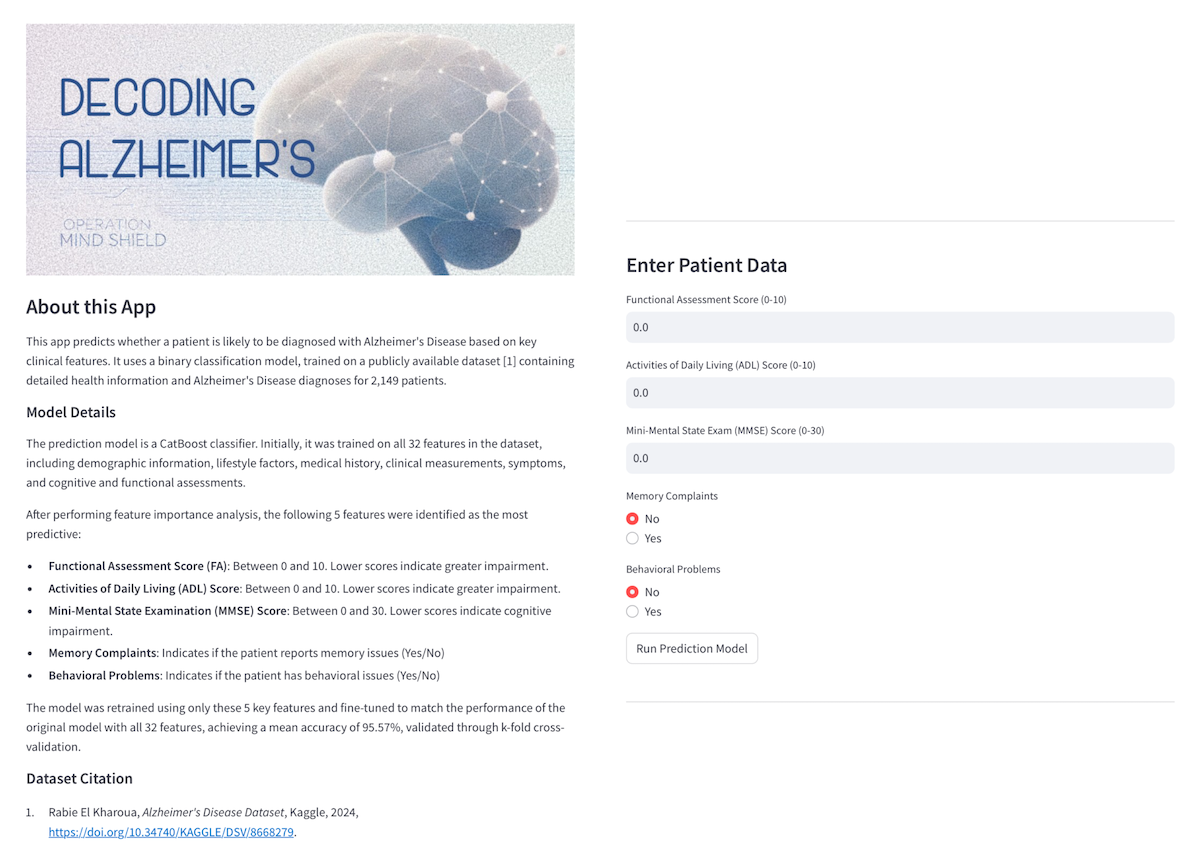

In [64]:
'''
----------app.py----------

import streamlit as st
from catboost import CatBoostClassifier
import numpy as np

# Load the trained CatBoost model
model = CatBoostClassifier()
model.load_model('alzheimers_model_optimized.cbm')

# App layout
st.image("header.png")

# Description
st.write("""
### About this App 
This app predicts whether a patient is likely to be diagnosed with Alzheimer's Disease based on key clinical features. 
It uses a binary classification model, trained on a publicly available dataset containing detailed health information 
and Alzheimer's Disease diagnoses for 2,149 patients.

##### Model Details
The prediction model is a CatBoost classifier. Initially, it was trained on all 32 features in the dataset, including 
demographic information, lifestyle factors, medical history, clinical measurements, symptoms, and cognitive and 
functional assessments. 
\n
After performing feature importance analysis, the following 5 features were identified as the most predictive:

- **Functional Assessment Score (FA)**: Between 0 and 10. Lower scores indicate greater impairment.
- **Activities of Daily Living (ADL) Score**: Between 0 and 10. Lower scores indicate greater impairment.
- **Mini-Mental State Examination (MMSE) Score**: Between 0 and 30. Lower scores indicate cognitive impairment.
- **Memory Complaints**: Indicates if the patient reports memory issues (Yes/No)
- **Behavioral Problems**: Indicates if the patient has behavioral issues (Yes/No)

The model was retrained using only these 5 key features and fine-tuned to match the performance of the original model 
with all 32 features, achieving a mean accuracy of 95.57%, validated through k-fold cross-validation.

##### Dataset Citation
Rabie El Kharoua. Alzheimer's Disease Dataset. Kaggle, 2024, https://doi.org/10.34740/KAGGLE/DSV/8668279.

""")

# Get user input
st.write("""
---
### Enter Patient Data
""")
fa = st.text_input("Functional Assessment Score (0-10)", value="0.0")
adl = st.text_input("Activities of Daily Living (ADL) Score (0-10)", value="0.0")
mmse = st.text_input("Mini-Mental State Exam (MMSE) Score (0-30)", value="0.0")

memory_complaints = st.radio("Memory Complaints", ('No', 'Yes'))
behavioral_problems = st.radio("Behavioral Problems", ('No', 'Yes'))

# Encode categorical variables
mc = 1 if memory_complaints == 'Yes' else 0
bp = 1 if behavioral_problems == 'Yes' else 0

# Run prediction model and show result
if st.button('Run Prediction Model'):
    try:
        fa = float(fa)
        adl = float(adl)
        mmse = float(mmse)
        
        # Check if the values are within the predefined ranges
        if not (0 <= fa <= 10):
            st.error("Functional Assessment Score must be between 0 and 10.")
        elif not (0 <= adl <= 10):
            st.error("ADL Score must be between 0 and 10.")
        elif not (0 <= mmse <= 30):
            st.error("MMSE Score must be between 0 and 30.")
        else:
            input_data = np.array([[fa, adl, mmse, mc, bp]])

            prediction = model.predict(input_data)
            
            if prediction[0] == 1:
                st.success("Positive Alzheimer's diagnosis likely.")
            else:
                st.error("Negative Alzheimer's diagnosis likely.")
    
    except ValueError:
        st.error("Please ensure that all inputs are numeric.")
st.write("""
---
""")

----------app.py----------
''';